# Прогноз дохода клиентов

 - Задача прогнозирования дохода имеет особенное значение в Банке.
Эта информация помогает точнее и более релевантно подбирать продукты и условия их приобретения, что в свою очередь вносит существенный вклад в прибыль Банка.
 - Помимо ценности для Банка, оценка дохода является регуляторным требованием ЦБ в части расчета предельно допустимой кредитной нагрузки для клиента (далее ПДН)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# здесь меняю рабочую папку, чтобы путь не прописывать к ней все время
import os
for dirpath, dirnames, _ in os.walk('/content/drive/MyDrive'):
    if 'hackathon' in dirnames:
        os.chdir(os.path.join(dirpath, 'hackathon'))
        break

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

In [2]:
def weighted_mean_absolute_error(y_true, y_pred, weights):
    return (weights * np.abs(y_true - y_pred)).mean()

In [6]:
train_df = pd.read_csv('hackathon_income_train.csv', decimal=',', sep=';')
test_df = pd.read_csv('hackathon_income_test.csv', decimal=',', sep=';')
train_df.shape, test_df.shape

/tmp/ipython-input-3956870551.py:1: DtypeWarning: Columns (66) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('hackathon_income_train.csv', decimal=',', sep=';')
/tmp/ipython-input-3956870551.py:2: DtypeWarning: Columns (65) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv('hackathon_income_test.csv', decimal=',', sep=';')


((76786, 224), (73214, 222))

In [7]:
train_df.head(5)

,id,dt,target,turn_cur_cr_avg_act_v2,salary_6to12m_avg,hdb_bki_total_max_limit,dp_ils_paymentssum_avg_12m,hdb_bki_total_cc_max_limit,incomeValue,gender,...,dp_ils_uniq_companies_1y,avg_6m_travel,avg_6m_government_services,hdb_bki_active_cc_max_overdue,total_rur_amt_cm_avg_period_days_ago_v2,label_Above_1M_share_r1,transaction_category_supermarket_sum_cnt_d15,max_balance_rur_amt_1m_af,w,first_salary_income
0,2,2024-04-30,109324.476325,1465144.960,NaN,52800.0,365346.244634,23213.0,97366.0,Женский,...,1.0,0.0,57.0,0.0,297.0,0.027027,9.0,NaN,0.301217,NaN
1,4,2024-02-29,25558.028662,303593.660,NaN,260200.0,NaN,10000.0,32580.0,Женский,...,NaN,0.0,707.0,67.0,30245.0,NaN,2.0,NaN,0.695800,NaN
2,5,2024-02-29,40666.753098,490754.010,NaN,2000000.0,NaN,90000.0,96866.0,Женский,...,NaN,422.0,0.0,0.0,210322.0,0.000000,20.0,NaN,0.515970,NaN
3,6,2024-04-30,43856.672058,219875.120,NaN,75000.0,NaN,75000.0,43860.0,Мужской,...,NaN,0.0,0.0,0.0,7187.0,0.000000,7.0,NaN,0.478003,NaN
4,7,2024-04-30,130420.851992,1750241.845,NaN,1000000.0,NaN,240000.0,83815.0,Женский,...,NaN,0.0,84.0,0.0,690038.0,0.000000,9.0,NaN,0.552314,NaN


# Анализ и обучение

In [8]:
y = train_df['target']
w = train_df['w']

X = train_df.drop(columns=["target", "id", "dt", "w"])

In [9]:
print(f'Общее кол-во столбцов {X.shape[1]}')
print(X.dtypes.value_counts())

Общее кол-во столбцов 220
float64    180
object      40
Name: count, dtype: int64


In [10]:
X = X.loc[:, X.isnull().mean() < 0.5] # оставим только столбцы, где пропусков меньше 50%

In [11]:
object_cols = X.select_dtypes(include="object").columns.tolist()
numeric_cols = X.select_dtypes(include="float64").columns.tolist()

In [12]:
categorical_cols = []
for col in object_cols:
    try:
      X[col] = pd.to_numeric(X[col].dropna())
    except ValueError:
      categorical_cols.append(col)

In [13]:
categorical_cols

['gender', 'adminarea', 'city_smart_name', 'addrref']

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, w, test_size=0.2, random_state=42
)

In [15]:
for col in categorical_cols:
    X_train[col] = X_train[col].astype(str).fillna("nan")
    X_test[col] = X_test[col].astype(str).fillna("nan")

<Axes: >

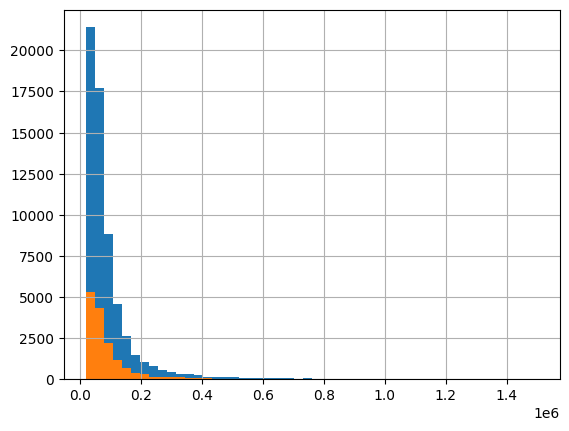

In [16]:
y_train.hist(bins=50)
y_test.hist(bins=50)

In [17]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

w_train_log = w_train / w_train.mean()
w_test_log  = w_test / w_test.mean()

<Axes: >

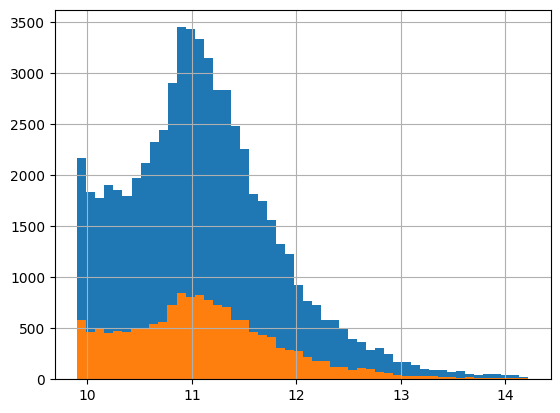

In [18]:
y_train_log.hist(bins=50)
y_test_log.hist(bins=50)

In [19]:
# заполняем пропуски медианой
numeric_cols = X.select_dtypes(include="float64").columns

for col in numeric_cols:
    median = X_train[col].median()
    X_train[col] = X_train[col].fillna(median)
    X_test[col] = X_test[col].fillna(median)

In [20]:
X_train.isnull().sum().sum() # общее кол-во nan во всем датафрейме

np.int64(0)

In [21]:
# найдем столбцы, где присутсвуют выбросы
numeric_cols = X_train.select_dtypes(include='float64').columns

outliers = {}
for col in numeric_cols:
    q1 = X_train[col].quantile(0.25)
    q3 = X_train[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    count = ((X_train[col] < lower_bound) | (X_train[col] > upper_bound)).sum()

    outliers[col] = count

for col, count in outliers.items():
    if count > 0:
        print(f"{col}: {count}")

turn_cur_cr_avg_act_v2: 6445
hdb_bki_total_max_limit: 5823
hdb_bki_total_cc_max_limit: 5477
incomeValue: 4455
avg_cur_cr_turn: 6929
turn_cur_cr_avg_v2: 7001
turn_cur_cr_max_v2: 9263
hdb_bki_total_pil_max_limit: 5950
age: 291
turn_cur_cr_sum_v2: 7001
turn_cur_db_sum_v2: 7004
turn_cur_db_avg_act_v2: 6510
curr_rur_amt_cm_avg: 7827
turn_cur_db_avg_v2: 7004
avg_cur_db_turn: 6926
hdb_bki_active_cc_max_limit: 6150
incomeValueCategory: 670
avg_by_category__amount__sum__cashflowcategory_name__vydacha_nalichnyh_v_bankomate: 19924
avg_credit_turn_rur: 7639
by_category__amount__sum__eoperation_type_name__perevod_po_nomeru_telefona: 30190
turn_cur_cr_7avg_avg_v2: 6604
curbal_usd_amt_cm_avg: 10198
avg_by_category__amount__sum__cashflowcategory_name__supermarkety: 9303
avg_by_category__amount__sum__cashflowcategory_name__gipermarkety: 10622
uniV5: 6196
turn_cur_db_max_v2: 9011
avg_by_category__amount__sum__cashflowcategory_name__kafe: 9976
turn_other_db_max_v2: 10366
turn_cur_cr_min_v2: 6466
turn_cur

In [22]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [27]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(
    iterations=1800,
    learning_rate=0.03,
    depth=8,
    loss_function="MAE",
    random_seed=42
)

model.fit(X_train, y_train_log, cat_features=categorical_cols, sample_weight=w_train_log)

0:	learn: 0.9483779	total: 351ms	remaining: 10m 32s
1:	learn: 0.9388379	total: 558ms	remaining: 8m 21s
2:	learn: 0.9291654	total: 768ms	remaining: 7m 40s
3:	learn: 0.9198691	total: 1.03s	remaining: 7m 44s
4:	learn: 0.9109923	total: 1.29s	remaining: 7m 43s
5:	learn: 0.9023641	total: 1.55s	remaining: 7m 44s
6:	learn: 0.8936939	total: 1.79s	remaining: 7m 39s
7:	learn: 0.8855797	total: 2.06s	remaining: 7m 41s
8:	learn: 0.8779040	total: 2.31s	remaining: 7m 38s
9:	learn: 0.8703779	total: 2.71s	remaining: 8m 5s
10:	learn: 0.8629502	total: 2.92s	remaining: 7m 54s
11:	learn: 0.8555427	total: 3.16s	remaining: 7m 50s
12:	learn: 0.8484968	total: 3.42s	remaining: 7m 49s
13:	learn: 0.8415322	total: 3.65s	remaining: 7m 46s
14:	learn: 0.8349590	total: 3.87s	remaining: 7m 40s
15:	learn: 0.8282857	total: 4.2s	remaining: 7m 48s
16:	learn: 0.8223635	total: 4.44s	remaining: 7m 45s
17:	learn: 0.8162586	total: 4.69s	remaining: 7m 44s
18:	learn: 0.8101500	total: 4.95s	remaining: 7m 43s
19:	learn: 0.8042617	to

In [29]:
preds_log = model.predict(X_test)
preds = np.expm1(preds_log)
print("WMAE:", weighted_mean_absolute_error(y_test, preds, w_test))

WMAE: 48341.77147492234


In [30]:
from sklearn.metrics import r2_score

r2_score(y_test, preds)

0.47698635337610396